<a href="https://colab.research.google.com/github/Alfikriangelo/MachineLearningTasks/blob/main/11thWeekTask/Heart_Disease_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
data = pd.read_csv('sample_data/heart.csv')

In [4]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [35]:
#Check missing values
print(data.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [5]:
# Split features and target
X = data.drop(columns=["target"])
y = data["target"]

In [6]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# PyTorch Tensors for MLP
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.long)
y_test_torch = torch.tensor(y_test.values, dtype=torch.long)

In [9]:
# PyTorch MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons_per_layer, activation_fn):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size

        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_features, neurons_per_layer))
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation_fn == 'tanh':
                layers.append(nn.Tanh())
            in_features = neurons_per_layer

        layers.append(nn.Linear(neurons_per_layer, 2))  # Output layer (binary classification)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [10]:
# Train PyTorch Model
def train_model(model, X_train, y_train, X_test, y_test, epochs, lr, batch_size):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader = torch.utils.data.DataLoader(
        dataset=torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
    )

    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

In [11]:
# Hyperparameter options
hidden_layers_options = [1, 2, 3]
neurons_per_layer_options = [16, 32, 64]
activation_functions = ['relu', 'sigmoid']
epochs_options = [25, 50, 250]
learning_rates = [0.1, 0.001, 0.0001]
batch_sizes = [64, 128, 256]

In [12]:
# Results storage
results = []

In [13]:
# Iterate over all combinations of hyperparameters
for hidden_layers, neurons_per_layer, activation_fn, epochs, lr, batch_size in itertools.product(
    hidden_layers_options,
    neurons_per_layer_options,
    activation_functions,
    epochs_options,
    learning_rates,
    batch_sizes,
):
    # Initialize model with current hyperparameters
    model = MLP(X_train_torch.shape[1], hidden_layers, neurons_per_layer, activation_fn)

    # Train model
    train_model(model, X_train_torch, y_train_torch, X_test_torch, y_test_torch, epochs, lr, batch_size)

    # Evaluate model
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_torch)
        _, predictions = torch.max(outputs, 1)
        accuracy = (predictions == y_test_torch).float().mean().item()

    # Save results
    results.append({
        'hidden_layers': hidden_layers,
        'neurons_per_layer': neurons_per_layer,
        'activation_fn': activation_fn,
        'epochs': epochs,
        'learning_rate': lr,
        'batch_size': batch_size,
        'accuracy': accuracy
    })


In [14]:
# Sort results by accuracy
sorted_results = sorted(results, key=lambda x: x['accuracy'], reverse=True)

In [15]:
# Print top 5 configurations
print("Top 5 Hyperparameter Configurations:")
for result in sorted_results[:5]:
    print(result)

Top 5 Hyperparameter Configurations:
{'hidden_layers': 1, 'neurons_per_layer': 32, 'activation_fn': 'sigmoid', 'epochs': 250, 'learning_rate': 0.1, 'batch_size': 64, 'accuracy': 1.0}
{'hidden_layers': 1, 'neurons_per_layer': 32, 'activation_fn': 'sigmoid', 'epochs': 250, 'learning_rate': 0.1, 'batch_size': 128, 'accuracy': 1.0}
{'hidden_layers': 2, 'neurons_per_layer': 32, 'activation_fn': 'sigmoid', 'epochs': 250, 'learning_rate': 0.1, 'batch_size': 128, 'accuracy': 1.0}
{'hidden_layers': 2, 'neurons_per_layer': 64, 'activation_fn': 'sigmoid', 'epochs': 250, 'learning_rate': 0.1, 'batch_size': 64, 'accuracy': 1.0}
{'hidden_layers': 3, 'neurons_per_layer': 16, 'activation_fn': 'sigmoid', 'epochs': 250, 'learning_rate': 0.1, 'batch_size': 256, 'accuracy': 1.0}


In [16]:
# TensorFlow Model
model_tf = Sequential([
    Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model_tf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_tf.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - AUC: 0.6761 - accuracy: 0.6049 - loss: 0.6713 - val_AUC: 0.7777 - val_accuracy: 0.7012 - val_loss: 0.5899
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7987 - accuracy: 0.7110 - loss: 0.5626 - val_AUC: 0.8291 - val_accuracy: 0.7805 - val_loss: 0.5212
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8590 - accuracy: 0.7859 - loss: 0.4798 - val_AUC: 0.8450 - val_accuracy: 0.7866 - val_loss: 0.4866
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8725 - accuracy: 0.7846 - loss: 0.4527 - val_AUC: 0.8545 - val_accuracy: 0.7866 - val_loss: 0.4668
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8942 - accuracy: 0.8024 - loss: 0.4110 - val_AUC: 0.8627 - val_accuracy: 0.7866 - val_loss: 0.4540
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9304 - accuracy: 0.8436 - loss: 0.3519 - val_AUC: 0.8685 - val_accuracy: 0.7988 - val_loss: 0.4462
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.8

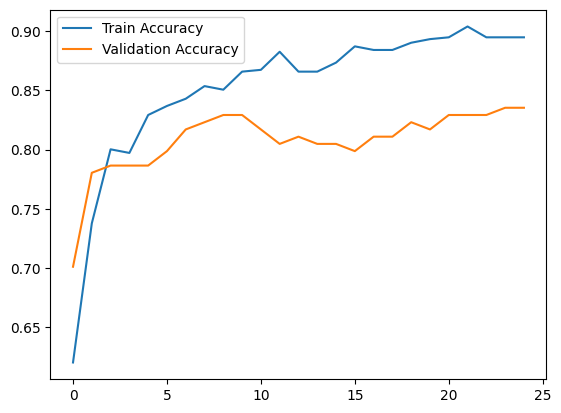

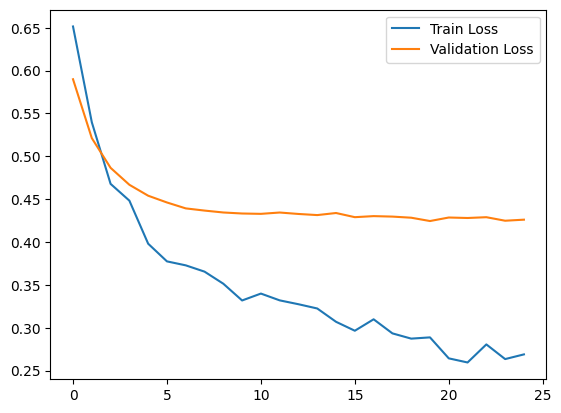

In [17]:
# Plot Accuracy and Loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [18]:
# Evaluate the TensorFlow Model
test_loss, test_accuracy, test_auc = model_tf.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}, AUC: {test_auc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9140 - accuracy: 0.8514 - loss: 0.3765 
Test Accuracy: 0.83, AUC: 0.90


In [19]:
# Predictions
y_pred = model_tf.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_binary))
print("AUC:", roc_auc_score(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       102
           1       0.78      0.93      0.85       103

    accuracy                           0.83       205
   macro avg       0.85      0.83      0.83       205
weighted avg       0.85      0.83      0.83       205

AUC: 0.905577765086617


In [28]:
# Convert to NumPy for metrics calculation
y_test_np = y_test_torch.numpy()
predictions_np = predictions.numpy()

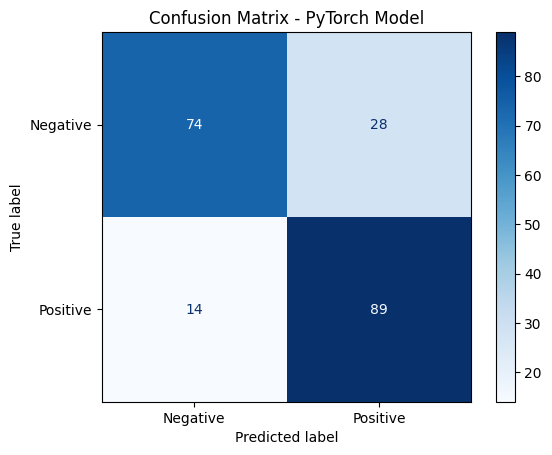

In [30]:
# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - PyTorch Model")
plt.show()